# Setup

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import os

import sklearn.metrics
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
drive.mount("/content/drive", force_remount=True)
root = "/content/drive/My Drive/Horse Category Classification"
os.chdir(root)
data_root = root + "/data"
data_root_train = data_root + "/train"
data_root_test = data_root + "/test"

Mounted at /content/drive


In [84]:
BATCH_SIZE = 32
HEIGHT = 224
WIDTH = 224

# 02 Overfit

In this notebook I am loading the train data and training it for many epochs. want to see whether I can overfit it to perfect (1.0) F1 Scores. That would mean that the model can perform the basic task that I am after. As a model I am using a basic mobilenet because it is small and retrained it for my purposes.

In [ ]:
class_names=['heavy', 'light', 'pony']

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="training"
)

In [96]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root_train,
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(HEIGHT, WIDTH),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    crop_to_aspect_ratio=False
)

Found 477 files belonging to 3 classes.
Using 95 files for validation.


In [86]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [87]:
def recompile_custom_output(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional ResNet50 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after'* setting layers to non-trainable)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [88]:
mobileNet = MobileNet(weights='imagenet', include_top=False)
model = recompile_custom_output(mobileNet)

In [89]:
callbacks = EarlyStopping(monitor='loss', mode = "min", patience=5)

In [90]:
epochs=50
history = model.fit(
  train_ds,
  epochs=epochs,
  callbacks = callbacks
)

Epoch 1/50
12/12 [==============================] - 20s 1s/step - loss: 3.7592 - accuracy: 0.3796
Epoch 2/50
12/12 [==============================] - 16s 1s/step - loss: 1.1993 - accuracy: 0.4476
Epoch 3/50
12/12 [==============================] - 15s 1s/step - loss: 0.9403 - accuracy: 0.5916
Epoch 4/50
12/12 [==============================] - 15s 1s/step - loss: 0.8899 - accuracy: 0.6178
Epoch 5/50
12/12 [==============================] - 16s 1s/step - loss: 0.7900 - accuracy: 0.6309
Epoch 6/50
12/12 [==============================] - 15s 1s/step - loss: 0.7964 - accuracy: 0.6204
Epoch 7/50
12/12 [==============================] - 15s 1s/step - loss: 0.7552 - accuracy: 0.6990
Epoch 8/50
12/12 [==============================] - 15s 1s/step - loss: 0.5658 - accuracy: 0.7775
Epoch 9/50
12/12 [==============================] - 16s 1s/step - loss: 0.7564 - accuracy: 0.6885
Epoch 10/50
12/12 [==============================] - 15s 1s/step - loss: 0.4755 - accuracy: 0.8115
Epoch 11/50
12/12 [

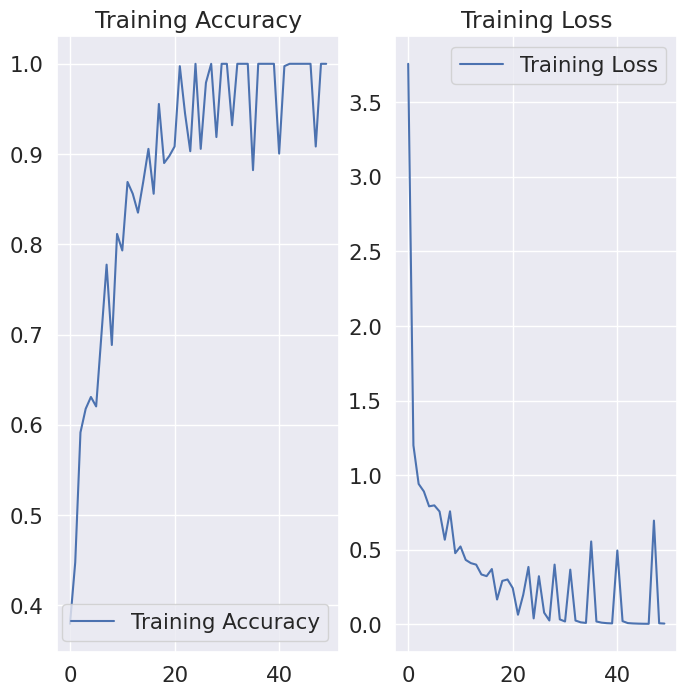

In [101]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [92]:
def labels_categorical_batch_dataset(ds):
    import numpy as np

    test_ls = list(ds.as_numpy_iterator())
    true_labels = []
    for batch in test_ls:
        for batchitem in batch[1].tolist():
            true_labels.append(np.argmax(batchitem))
    return true_labels

def plot_cm(confusion_matrix, class_names):
    import pandas as pd
    import seaborn as sn
    import matplotlib.pyplot as plt

    df_cm = pd.DataFrame(confusion_matrix, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 12}, fmt='g')

In [93]:
trainset_predictions = model.predict(train_ds)
train_predicted_labels = [prediction.argmax() for prediction in trainset_predictions]
train_true_labels = labels_categorical_batch_dataset(train_ds)

12/12 [==============================] - 26s 2s/step


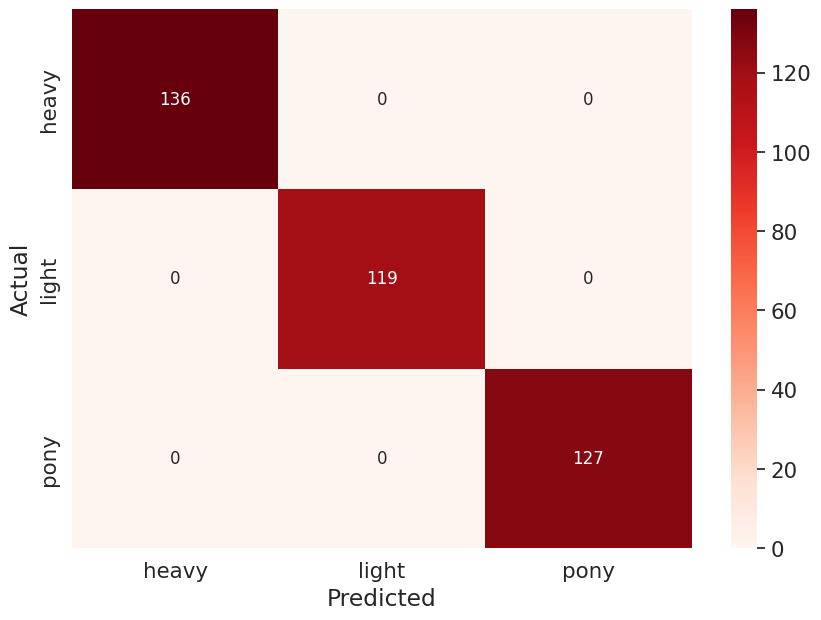

In [94]:
confusion_matrix_train = np.array(tf.math.confusion_matrix(train_true_labels, train_predicted_labels))
confusion_matrix_train = tf.math.confusion_matrix(train_true_labels, train_predicted_labels)
plot_cm(confusion_matrix_train, class_names)

In [95]:
print(classification_report(train_true_labels,train_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00       127

    accuracy                           1.00       382
   macro avg       1.00      1.00      1.00       382
weighted avg       1.00      1.00      1.00       382



In [97]:
valset_predictions = model.predict(val_ds)
val_predicted_labels = [prediction.argmax() for prediction in valset_predictions]
val_true_labels = labels_categorical_batch_dataset(val_ds)

3/3 [==============================] - 9s 1s/step


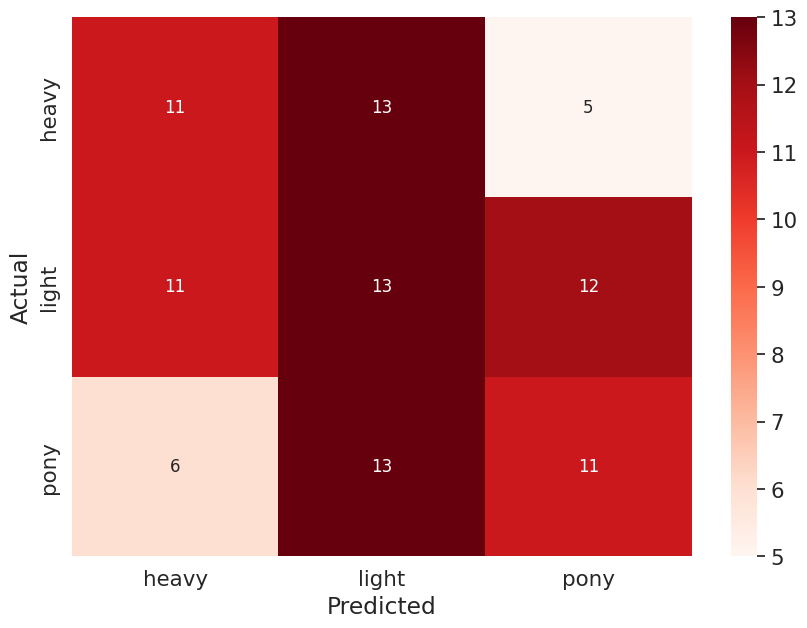

In [98]:
confusion_matrix_val = np.array(tf.math.confusion_matrix(val_true_labels, val_predicted_labels))
confusion_matrix_val = tf.math.confusion_matrix(val_true_labels, val_predicted_labels)
plot_cm(confusion_matrix_val, class_names)

In [99]:
print(classification_report(val_true_labels,val_predicted_labels))

              precision    recall  f1-score   support

           0       0.39      0.38      0.39        29
           1       0.33      0.36      0.35        36
           2       0.39      0.37      0.38        30

    accuracy                           0.37        95
   macro avg       0.37      0.37      0.37        95
weighted avg       0.37      0.37      0.37        95



# Summary

I trained the model for 50 epochs and it provided me with the perfect F1 scores for the training. In the validation data it becomes clear that it obviously wildly overfittet which was the goal. At this point it is no use to look at the test data. The next step is all about regularizing.